### v3 
Add "Some Notes" and then need to run remport with All Disaggreated just to track  Specs positioning.

In [1]:
import datetime as dt
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import BDay #use last BD to bypass feed issues on hols and early mrng
#import datetime as dt#  --->NameError: name 'datetime' is not defined
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DownloadData_v2

import os
import importlib.machinery
import sys


pd.set_option('display.max_rows', 200) #https://stackoverflow.com/questions/16424493/pandas-setting-no-of-max-rows
pd.options.display.max_rows 
#pd.set_option('display.max_columns', 60) #https://stackoverflow.com/questions/16424493/pandas-setting-no-of-max-rows
pd.options.display.max_columns = None
cwd = os.getcwd()

#sys.path #returns all working directories 
print(cwd)
#sys.path

C:\Users\cp85vc


#### Some notes
https://www.cftc.gov/MarketReports/CommitmentsofTraders/DisaggregatedExplanatoryNotes/index.htm

CFTC began publishing a Disaggregated Commitments of Traders (Disaggregated COT) report on September 4, 2009. The first iteration of the report covered 22 major physical commodity markets; on December 4, 2009, the remaining physical commodity markets were included.1

The Disaggregated COT report increases transparency from the legacy COT reports by separating traders into the following four categories of traders: Producer/Merchant/Processor/User; Swap Dealers; Managed Money; and Other Reportables. The legacy COT report separates reportable traders only into “commercial” and “non-commercial” categories.

***
This initiative for providing market transparency arises from the recommendation to disaggregate the existing “commercial” category in the Commission’s September 2008 Staff Report on Commodity Swap Dealers & Index Traders.3 Specifically, that report recommended:

Remove Swap Dealer from Commercial Category and Create New Swap Dealer Classification for Reporting Purposes: In order to provide for increased transparency of the exchange traded futures and options markets, the Commission has instructed the staff to develop a proposal to enhance and improve the CFTC‘s weekly Commitments of Traders Report by including more delineated trader classification categories beyond commercial and non-commercial, which may include at a minimum the addition of a separate category identifying the trading of swap dealers.

***

On {COT GO} in BBG you have as standard All Legacy (top left), then can toggle to get All Disaggregated. There is decent amount of diffenrce in magnitude though change semes to match somewhat .

In [2]:
#def download_format_data(secs, start , end, asset_class):
    
'''the COT report comes out on a Friday.....but for data of prev TUESDAY. So if blpapi calls both
underlyings' weekly (which is marked for friday) and COT , we get mismatches.
so we are foced to call the undelrying on a daily and then merge.
secs dictionary of securities, 
start & end datetime objects
asset_class = 'Crncy', 'Comdty' '''

start_ = dt.datetime(2012, 3 , 9)
end_ = dt.datetime.today() #dt.datetime(2021, 10,12)

frequency = 'WEEKLY'
asset_class = 'CURNCY'

'''
can get tickers from COT <GO>
i dont look at ES as not sure how much that tells us ..what are even commercials there? 
spec shorts hedging component longs? 
can add commos i think
'''

secs = {'AUDUSD' : ['IMM6ANCL Index', 'IMM6ANCS Index'],#ctr size: AUD100k,ctr value: price$/aud * 100k Aud = 80kish
        'EURUSD' : ['IMMBENCL Index', 'IMMBENCS Index'],
        'GBPUSD' : ['IMM5PNCL Index', 'IMM5PNCS Index'],
        'NZDUSD' : ['IMM6ZNCL Index', 'IMM6ZNCS Index'],
        'USDCAD' : [ 'IMM3CNCL Index', 'IMM3CNCS Index'],
       'USDJPY' : ['IMM5JNCL Index', 'IMM5JNCS Index']} #ctr size: JPY12.5mio, ctr value: 88$/100yen *ctr size..$110kish..also upside down btw so higher means weaker usd, lower means stronger.

rates = {'TU1' : ['CBT42NCL Index', 'CBT42NCS Index'], #ZN  = TU
        'FV1':['CBT55NCL Index', 'CBT55NCS Index'], #FV = ZF
        'TY1': ['CBT4TNCL Index', 'CBT4TNCS Index'], #TY = ZT
        'US1': [' CBT3TNCL Index', 'CBT3TNCS Index']} #US = ZB

def download_format_data(secs, start, end, asset_class, zscore_window):
    
    #create list of securiteis names to feed in dictionary below  
    titles = []
    for sec in secs:
        titles.append(sec)

    datasets = {} #contians weekly values
    underlyings = {} #containts daily values
    merged = {}

    i  = 0 
    for sec in secs.values():
        #downlowad COT data, WEEKLY as released every FRIDAY (except  holidays) for preceding TUESDAY
        datasets[titles[i]] = DownloadData_v2.DownloadData(pair = sec, \
                                                     fields = ['PX_LAST'], \
                                                     startDate = start_, \
                                                     endDate = end_, \
                                                     period = 'WEEKLY', \
                                                    source = 'blp').get_data_blp_historical()
        #donwload underlyings , DAILY..to match above TUESDAY

        underlyings[titles[i]] = DownloadData_v2.DownloadData(pair = titles[i]+str(' '+asset_class) , \
                                                     fields = ['PX_LAST'], \
                                                     startDate = start_, \
                                                     endDate = end_, \
                                                     period = 'DAILY', \
                                                    source = 'blp').get_data_blp_historical()

        #merge COT weekly tuesdays with EOD dailys
        merged[titles[i]]   = pd.merge(datasets[titles[i]], underlyings[titles[i]], how = 'inner' , left_index = True, \
                                       right_index = True).set_axis([sec[0], sec[1], titles[i]], axis = 'columns')

        #reorder columns:  merged[AUDUSD] = merged['AUDUSD']['AUDUSD', 'IMM6ANCL', 'IMM6ANCS']
        merged[titles[i]] = merged[titles[i]]   [[titles[i], sec[0], sec[1] ]]

        #format:  add  net position 
        merged[titles[i]]['net_spec'] =  merged[titles[i]][sec[0]] - merged[titles[i]][sec[1]] 
        
        #add weekly change in net position
        merged[titles[i]]['weekly_change'] = merged[titles[i]]['net_spec'] - merged[titles[i]]['net_spec'].shift(1)
       
        #then add z score
        r = merged[titles[i]]['net_spec'].rolling(window = zscore_window)
        m = r.mean().shift(1)
        s = r.std(ddof = 0).shift(1)
        z = (merged[titles[i]]['net_spec']-m)/s
        merged[titles[i]]['z_score'] = round(z,3)
        
        
        #horrendous syntax below:  merged[titles[i]]blabla -> merged['USDJPY'][str()'USDJPY')+'_in_bio']
        
        if 'USDJPY' in titles[i]:
        # dollar amount of spec position for yen is 12.5mio yen per contr * net_spec /  spot (ie 113 yen per $)..so a positive amount is market long Yen/ Short USD and viceverdsa 
            merged[titles[i]][str(titles[i])+str('_bio')] = round(12.5e6 * merged[titles[i]]['net_spec'] / \
                                                                     merged[titles[i]][titles[i]] ) /1e9                                                                                                                                                                                 

            merged[titles[i]][str(titles[i])+str('_week_chng_bio')] =merged[titles[i]][str(titles[i])+str('_bio')]\
            - merged[titles[i]][str(titles[i])+str('_bio')].shift(1)
        else:
        # dollar amount of spec position is 100k eur  per contract spot (ie 1.13usd per eur) * net_spec ..so a positive amount is client long EUR  
            merged[titles[i]][str(titles[i])+str('_bio')] = round(merged[titles[i]][titles[i]] * \
                                                                  merged[titles[i]]['net_spec']*100e3)/1e9 #ADA1 comb Curncy ..contract size 100k

            merged[titles[i]][str(titles[i])+'_week_chng_bio'] =merged[titles[i]][str(titles[i])+str('_bio')]\
            - merged[titles[i]][str(titles[i])+str('_bio')].shift(1)
        #append descirptive stats..aobut 8 rows to chop if graph
        #merged[titles[i]] = merged[titles[i]].append(merged[titles[i]].describe())
        i+= 1
        
    return merged


#taking 5 yr z scores to replicate Nomura's report
fx = download_format_data(secs = secs, start = start_ , end = end_, asset_class= 'CURNCY', zscore_window =  52*5)
rates = download_format_data(secs = rates, start = start_ , end = end_, asset_class= 'COMDTY', zscore_window = 52*5)


2023-01-05 09:11:17.882401
2023-01-05 09:11:17.882401
2023-01-05 09:11:17.882401
2023-01-05 09:11:17.882401
2023-01-05 09:11:17.882401
2023-01-05 09:11:17.882401
2023-01-05 09:11:17.882401
2023-01-05 09:11:17.882401
2023-01-05 09:11:17.882401
2023-01-05 09:11:17.882401
2023-01-05 09:11:17.882401
2023-01-05 09:11:17.882401
2023-01-05 09:11:17.882401
2023-01-05 09:11:17.882401
2023-01-05 09:11:17.882401
2023-01-05 09:11:17.882401
2023-01-05 09:11:17.882401
2023-01-05 09:11:17.882401
2023-01-05 09:11:17.882401
2023-01-05 09:11:17.882401


In [3]:
#inspect 
check = 'AUDUSD'
fx[check].tail(10).append(fx[check].describe())
#for pair in fx:
    #dispaly sucks  print(fx[pair].tail(15).append(fx[pair].describe()))

,AUDUSD,IMM6ANCL Index,IMM6ANCS Index,net_spec,weekly_change,z_score,AUDUSD_bio,AUDUSD_week_chng_bio
2022-10-25 00:00:00,0.639400,32159.000000,83605.000000,-51446.000000,-16087.000000,-0.601000,-3.289457,-1.058658
2022-11-01 00:00:00,0.639500,34148.000000,84680.000000,-50532.000000,914.000000,-0.566000,-3.231521,0.057936
2022-11-08 00:00:00,0.650700,33288.000000,79971.000000,-46683.000000,3849.000000,-0.430000,-3.037663,0.193859
2022-11-15 00:00:00,0.675600,33214.000000,77963.000000,-44749.000000,1934.000000,-0.357000,-3.023242,0.014420
2022-11-22 00:00:00,0.664900,32825.000000,75611.000000,-42786.000000,1963.000000,-0.282000,-2.844841,0.178401
2022-11-29 00:00:00,0.668800,35045.000000,79675.000000,-44630.000000,-1844.000000,-0.340000,-2.984854,-0.140013
2022-12-06 00:00:00,0.668800,36334.000000,76897.000000,-40563.000000,4067.000000,-0.187000,-2.712853,0.272001
2022-12-13 00:00:00,0.685500,35825.000000,73662.000000,-37837.000000,2726.000000,-0.079000,-2.593726,0.119127
2022-12-20 00:00:00,0.667800,31779.000000,65894.000000,-34115.000000,3722.000000,0.060000,-2.278200,0.315527
2022-12-27 00:00:00,0.673200,32955.000000,69746.000000,-36791.000000,-2676.000000,-0.035000,-2.476770,-0.198570


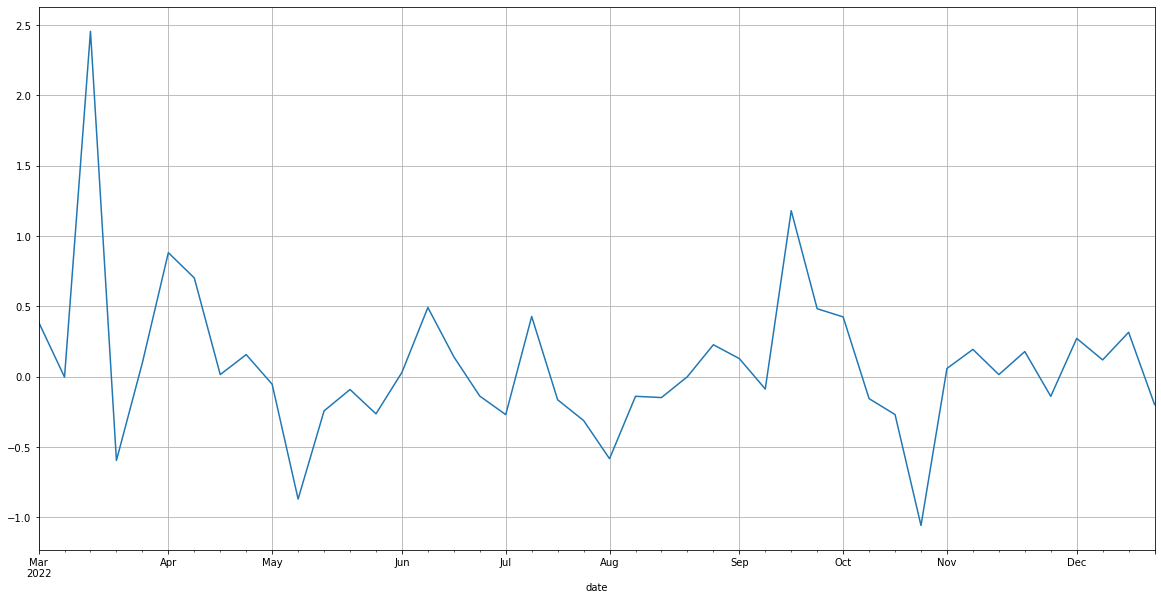

In [4]:
fx[check].iloc[(52*10):,-1].plot(figsize= (20,10), grid = True, kind = 'line')
#whole.iloc[-300:, arr == 0].plot(figsize = (20,10), grid = True, title = 'NonCommercialUSDPositioning', kind = 'line')

In [5]:
#inspect 
check = 'EURUSD'
fx[check].tail(10).append(fx[check].describe())

,EURUSD,IMMBENCL Index,IMMBENCS Index,net_spec,weekly_change,z_score,EURUSD_bio,EURUSD_week_chng_bio
2022-10-25 00:00:00,0.996600,226734.000000,151825.000000,74909.000000,26759.000000,0.510000,7.465431,2.718804
2022-11-01 00:00:00,0.987700,239770.000000,133980.000000,105790.000000,30881.000000,0.886000,10.448878,2.983447
2022-11-08 00:00:00,1.007400,232317.000000,124718.000000,107599.000000,1809.000000,0.906000,10.839523,0.390645
2022-11-15 00:00:00,1.034900,239369.000000,126703.000000,112666.000000,5067.000000,0.966000,11.659804,0.820281
2022-11-22 00:00:00,1.030400,239598.000000,116486.000000,123112.000000,10446.000000,1.091000,12.685460,1.025656
2022-11-29 00:00:00,1.033000,241122.000000,118875.000000,122247.000000,-865.000000,1.078000,12.628115,-0.057345
2022-12-06 00:00:00,1.046700,245063.000000,120180.000000,124883.000000,2636.000000,1.107000,13.071504,0.443389
2022-12-13 00:00:00,1.063300,236415.000000,111700.000000,124715.000000,-168.000000,1.104000,13.260946,0.189442
2022-12-20 00:00:00,1.062400,249149.000000,106877.000000,142272.000000,17557.000000,1.312000,15.114977,1.854031
2022-12-27 00:00:00,1.064000,251887.000000,105725.000000,146162.000000,3890.000000,1.354000,15.551637,0.436660


In [6]:
fx['EURUSD'][fx['EURUSD']['z_score']< -0.6]

,EURUSD,IMMBENCL Index,IMMBENCS Index,net_spec,weekly_change,z_score,EURUSD_bio,EURUSD_week_chng_bio
date,,,,,,,,
2019-04-23,1.1228,148331.0,253749.0,-105418.0,-7395.0,-0.615,-11.836333,-0.778358
2019-04-30,1.1216,153821.0,259365.0,-105544.0,-126.0,-0.612,-11.837815,-0.001482
2019-05-07,1.1191,152633.0,258738.0,-106105.0,-561.0,-0.612,-11.874211,-0.036396
2020-02-18,1.0792,170586.0,262093.0,-91507.0,-5838.0,-0.616,-9.875435,-0.524664
2020-02-25,1.0881,157587.0,271608.0,-114021.0,-22514.0,-0.879,-12.406625,-2.531190
2021-10-05,1.1598,196819.0,219153.0,-22334.0,-23206.0,-0.603,-2.590297,-2.692173
2021-11-30,1.1338,191048.0,214288.0,-23240.0,-6788.0,-0.679,-2.634951,-0.784430
2022-06-21,1.0533,195554.0,211159.0,-15605.0,-9587.0,-0.677,-1.643675,-1.016840
2022-06-28,1.0519,189414.0,200010.0,-10596.0,5009.0,-0.612,-1.114593,0.529081


In [7]:
#inspect 
check = 'USDJPY'
fx[check].tail(10).append(fx[check].describe())

,USDJPY,IMM5JNCL Index,IMM5JNCS Index,net_spec,weekly_change,z_score,USDJPY_bio,USDJPY_week_chng_bio
2022-10-25 00:00:00,147.940000,37579.000000,140197.000000,-102618.000000,-8282.000000,-1.267000,-8.670576,-0.770268
2022-11-01 00:00:00,148.270000,40460.000000,118080.000000,-77620.000000,24998.000000,-0.759000,-6.543805,2.126771
2022-11-08 00:00:00,145.680000,37201.000000,112459.000000,-75258.000000,2362.000000,-0.719000,-6.457475,0.086330
2022-11-15 00:00:00,139.280000,33797.000000,99639.000000,-65842.000000,9416.000000,-0.533000,-5.909140,0.548335
2022-11-22 00:00:00,141.230000,30800.000000,95650.000000,-64850.000000,992.000000,-0.520000,-5.739751,0.169389
2022-11-29 00:00:00,138.630000,28125.000000,95519.000000,-67394.000000,-2544.000000,-0.578000,-6.076787,-0.337036
2022-12-06 00:00:00,137.000000,23589.000000,89585.000000,-65996.000000,1398.000000,-0.555000,-6.021533,0.055254
2022-12-13 00:00:00,135.590000,22290.000000,75478.000000,-53188.000000,12808.000000,-0.292000,-4.903385,1.118148
2022-12-20 00:00:00,131.730000,33686.000000,74567.000000,-40881.000000,12307.000000,-0.038000,-3.879242,1.024144
2022-12-27 00:00:00,133.490000,29685.000000,67415.000000,-37730.000000,3151.000000,0.023000,-3.533036,0.346205


In [8]:
fx[check][fx[check]== fx[check]['z_score'].min()].dropna(axis = 1, thresh = 1).dropna() #returns lowest date 2012-12-11
fx[check][fx[check]['z_score']<-1]

,USDJPY,IMM5JNCL Index,IMM5JNCS Index,net_spec,weekly_change,z_score,USDJPY_bio,USDJPY_week_chng_bio
date,,,,,,,,
2017-07-11,113.94,40778.0,152903.0,-112125.0,-37089.0,-1.275,-12.300882,-4.020956
2017-07-18,112.07,37419.0,164338.0,-126919.0,-14794.0,-1.539,-14.156219,-1.855337
2017-07-25,111.89,28018.0,149507.0,-121489.0,5430.0,-1.426,-13.572370,0.583849
2017-08-01,110.36,36445.0,148641.0,-112196.0,9293.0,-1.243,-12.707956,0.864414
2017-10-24,113.90,60077.0,176934.0,-116857.0,-15571.0,-1.276,-12.824517,-1.540426
2017-10-31,113.64,54585.0,173454.0,-118869.0,-2012.0,-1.304,-13.075172,-0.250654
2017-11-07,114.00,54336.0,182184.0,-127848.0,-8979.0,-1.464,-14.018421,-0.943249
2017-11-14,113.46,49347.0,185346.0,-135999.0,-8151.0,-1.604,-14.983144,-0.964723
2017-11-21,112.45,44382.0,166984.0,-122602.0,13397.0,-1.340,-13.628502,1.354642


In [9]:
#get df with just bio position
df_bio = []
#filter each df in the dictionary for billions amounts
for df in fx.values():
    df_bio.append(df.filter(regex = 'bio'))

    
whole = pd.concat([df_bio[j] for j in range(len(df_bio))], join = 'outer', axis = 1)
pd.options.display.float_format = '{:,.2f}'.format

arr = np.arange(len(whole.columns)) % 2 #create array cols [0, 1, 0, 1...]
print(arr, len(arr))
whole['USD_bio'] = whole.iloc[:, arr == 0].sum(axis = 1)*-1

#arr = np.arange(len(whole.columns))%2
#print(arr, len(arr), whole.shape)


roll_array = whole['USD_bio'].rolling(window = 3)
m = roll_array.mean()
s = roll_array.std()
z = (whole['USD_bio'] - m)/s
whole['dollar_bio_zscore'] = z

arr = np.arange(len(whole.columns))%2
print(arr, len(arr), whole.shape)

whole.tail(10).append(whole.describe())

[0 1 0 1 0 1 0 1 0 1 0 1] 12
[0 1 0 1 0 1 0 1 0 1 0 1 0 1] 14 (564, 14)


,AUDUSD_bio,AUDUSD_week_chng_bio,EURUSD_bio,EURUSD_week_chng_bio,GBPUSD_bio,GBPUSD_week_chng_bio,NZDUSD_bio,NZDUSD_week_chng_bio,USDCAD_bio,USDCAD_week_chng_bio,USDJPY_bio,USDJPY_week_chng_bio,USD_bio,dollar_bio_zscore
2022-10-25 00:00:00,-3.29,-1.06,7.47,2.72,-5.48,0.31,-0.74,0.31,-2.47,0.36,-8.67,-0.77,13.19,-0.89
2022-11-01 00:00:00,-3.23,0.06,10.45,2.98,-5.15,0.34,-0.22,0.51,-2.41,0.06,-6.54,2.13,7.11,-1.13
2022-11-08 00:00:00,-3.04,0.19,10.84,0.39,-4.59,0.56,-0.38,-0.15,-2.48,-0.07,-6.46,0.09,6.10,-0.70
2022-11-15 00:00:00,-3.02,0.01,11.66,0.82,-3.90,0.69,-0.41,-0.03,-1.72,0.76,-5.91,0.55,3.29,-1.12
2022-11-22 00:00:00,-2.84,0.18,12.69,1.03,-4.27,-0.38,-0.26,0.14,-1.56,0.15,-5.74,0.17,2.00,-0.86
2022-11-29 00:00:00,-2.98,-0.14,12.63,-0.06,-4.37,-0.10,-0.31,-0.05,-2.19,-0.63,-6.08,-0.34,3.31,0.59
2022-12-06 00:00:00,-2.71,0.27,13.07,0.44,-3.42,0.95,-0.41,-0.10,-3.02,-0.83,-6.02,0.06,2.51,-0.14
2022-12-13 00:00:00,-2.59,0.12,13.26,0.19,-3.18,0.24,-0.49,-0.07,-3.69,-0.67,-4.90,1.12,1.59,-1.02
2022-12-20 00:00:00,-2.28,0.32,15.11,1.85,-0.68,2.50,0.40,0.89,-3.67,0.02,-3.88,1.02,-5.01,-1.15
2022-12-27 00:00:00,-2.48,-0.20,15.55,0.44,-1.31,-0.63,0.43,0.03,-4.06,-0.39,-3.53,0.35,-4.60,-0.52


,AUDUSD_bio,EURUSD_bio,GBPUSD_bio,NZDUSD_bio,USDCAD_bio,USDJPY_bio,USD_bio
date,,,,,,,
2022-10-25,-3.29,7.47,-5.48,-0.74,-2.47,-8.67,13.19
2022-11-01,-3.23,10.45,-5.15,-0.22,-2.41,-6.54,7.11
2022-11-08,-3.04,10.84,-4.59,-0.38,-2.48,-6.46,6.10
2022-11-15,-3.02,11.66,-3.90,-0.41,-1.72,-5.91,3.29
2022-11-22,-2.84,12.69,-4.27,-0.26,-1.56,-5.74,2.00
2022-11-29,-2.98,12.63,-4.37,-0.31,-2.19,-6.08,3.31
2022-12-06,-2.71,13.07,-3.42,-0.41,-3.02,-6.02,2.51
2022-12-13,-2.59,13.26,-3.18,-0.49,-3.69,-4.90,1.59
2022-12-20,-2.28,15.11,-0.68,0.40,-3.67,-3.88,-5.01


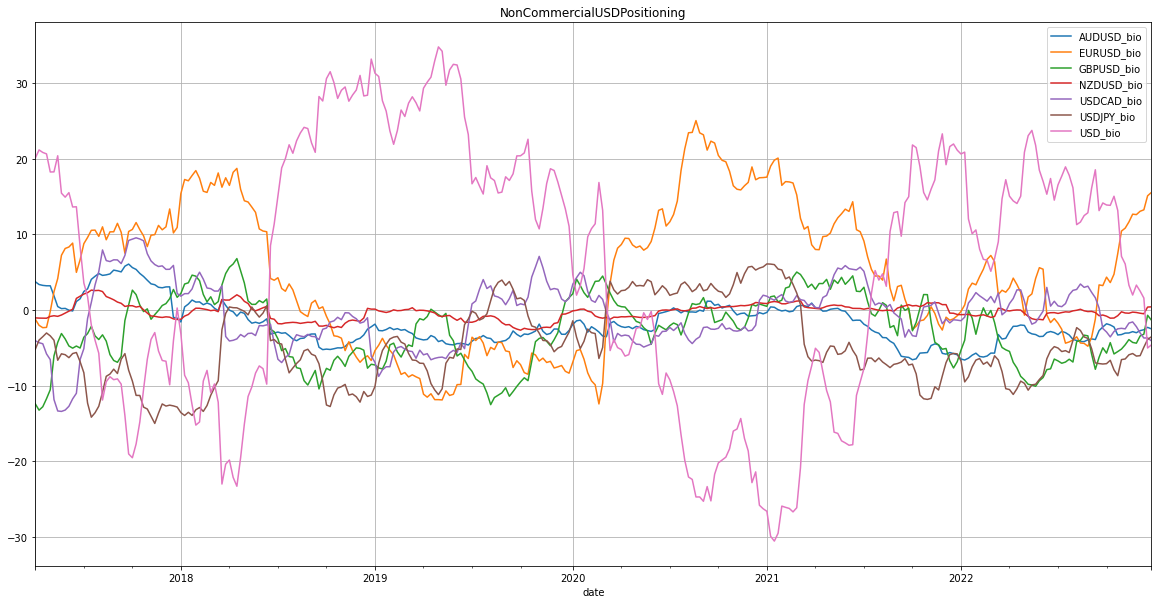

In [10]:
whole.iloc[-300:, arr == 0].plot(figsize = (20,10), grid = True, title = 'NonCommercialUSDPositioning', kind = 'line')
whole.iloc[-10:, arr == 0].tail(10)

In [11]:
rates['TU1'].tail(20).append(rates['TU1'].describe())

,TU1,CBT42NCL Index,CBT42NCS Index,net_spec,weekly_change,z_score,TU1_bio,TU1_week_chng_bio
2022-08-16 00:00:00,104.62,"180,858.00","394,906.00","-214,048.00","-41,827.00",-0.39,"-2,239.39",-438.88
2022-08-23 00:00:00,104.57,"178,737.00","419,880.00","-241,143.00","-27,095.00",-0.63,"-2,521.64",-282.25
2022-08-30 00:00:00,104.23,"108,397.00","389,997.00","-281,600.00","-40,457.00",-0.99,"-2,935.24",-413.60
2022-09-06 00:00:00,104.04,"89,223.00","415,965.00","-326,742.00","-45,142.00",-1.38,"-3,399.39",-464.15
2022-09-13 00:00:00,103.58,"100,196.00","458,377.00","-358,181.00","-31,439.00",-1.65,"-3,710.11",-310.72
2022-09-20 00:00:00,103.18,"139,358.00","481,773.00","-342,415.00","15,766.00",-1.50,"-3,533.03",177.08
2022-09-27 00:00:00,102.47,"154,887.00","474,764.00","-319,877.00","22,538.00",-1.28,"-3,277.86",255.16
2022-10-04 00:00:00,102.93,"154,321.00","460,455.00","-306,134.00","13,743.00",-1.15,"-3,150.91",126.96
2022-10-11 00:00:00,102.50,"143,277.00","496,963.00","-353,686.00","-47,552.00",-1.56,"-3,625.42",-474.51
2022-10-18 00:00:00,102.30,"143,755.00","479,267.00","-335,512.00","18,174.00",-1.39,"-3,432.18",193.24


In [12]:
rates['FV1'].tail(20).append(rates['FV1'].describe())

,FV1,CBT55NCL Index,CBT55NCS Index,net_spec,weekly_change,z_score,FV1_bio,FV1_week_chng_bio
2022-08-16 00:00:00,112.33,"265,741.00","733,116.00","-467,375.00","-116,372.00",-0.95,"-5,249.94","-1,310.75"
2022-08-23 00:00:00,111.38,"286,071.00","789,596.00","-503,525.00","-36,150.00",-1.12,"-5,608.01",-358.07
2022-08-30 00:00:00,110.79,"227,425.00","792,881.00","-565,456.00","-61,931.00",-1.42,"-6,264.63",-656.62
2022-09-06 00:00:00,110.16,"264,384.00","770,275.00","-505,891.00","59,565.00",-1.11,"-5,573.10",691.53
2022-09-13 00:00:00,109.49,"276,668.00","798,127.00","-521,459.00","-15,568.00",-1.18,"-5,709.57",-136.47
2022-09-20 00:00:00,108.72,"266,452.00","760,256.00","-493,804.00","27,655.00",-1.04,"-5,368.58",340.99
2022-09-27 00:00:00,106.68,"286,492.00","728,458.00","-441,966.00","51,838.00",-0.77,"-4,714.88",653.70
2022-10-04 00:00:00,108.38,"234,418.00","717,450.00","-483,032.00","-41,066.00",-0.97,"-5,234.86",-519.98
2022-10-11 00:00:00,106.92,"243,772.00","727,692.00","-483,920.00",-888.00,-0.97,"-5,174.16",60.70
2022-10-18 00:00:00,106.67,"219,782.00","707,359.00","-487,577.00","-3,657.00",-0.98,"-5,201.08",-26.91


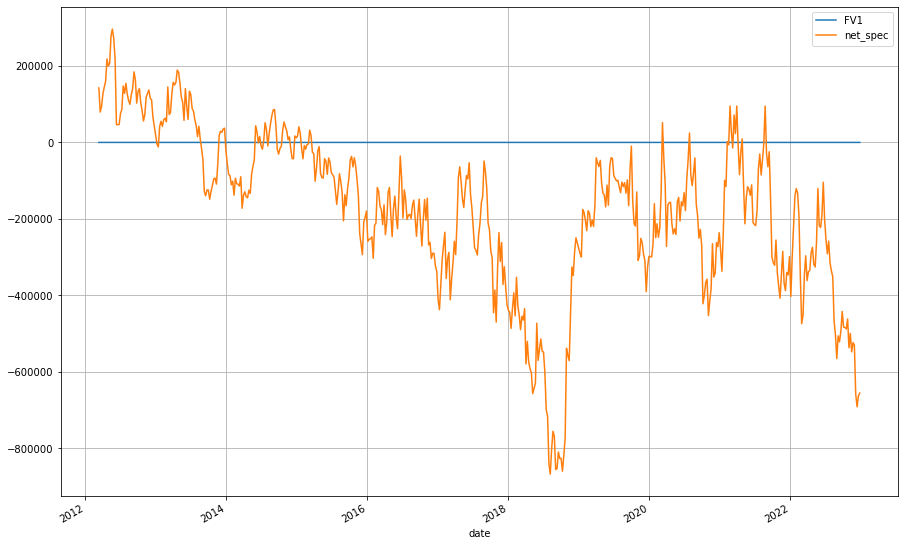

In [13]:
rates['FV1'].iloc[:, [0,3]].plot(figsize = (15,10), grid = True)

In [14]:
rates['TY1'].tail(20).append(rates['TY1'].describe())

,TY1,CBT4TNCL Index,CBT4TNCS Index,net_spec,weekly_change,z_score,TY1_bio,TY1_week_chng_bio
2022-08-16 00:00:00,119.39,"209,821.00","572,949.00","-363,128.00","-76,650.00",-0.91,"-4,335.41",-912.44
2022-08-23 00:00:00,117.62,"277,270.00","658,439.00","-381,169.00","-18,041.00",-0.98,"-4,483.50",-148.09
2022-08-30 00:00:00,117.00,"241,872.00","681,975.00","-440,103.00","-58,934.00",-1.25,"-5,149.21",-665.70
2022-09-06 00:00:00,115.59,"279,865.00","656,142.00","-376,277.00","63,826.00",-0.95,"-4,349.53",799.68
2022-09-13 00:00:00,114.95,"297,034.00","649,923.00","-352,889.00","23,388.00",-0.83,"-4,056.57",292.96
2022-09-20 00:00:00,113.84,"397,050.00","626,640.00","-229,590.00","123,299.00",-0.24,"-2,613.74","1,442.83"
2022-09-27 00:00:00,110.89,"316,478.00","681,670.00","-365,192.00","-135,602.00",-0.88,"-4,049.64","-1,435.90"
2022-10-04 00:00:00,113.50,"373,634.00","740,506.00","-366,872.00","-1,680.00",-0.89,"-4,164.00",-114.36
2022-10-11 00:00:00,111.14,"382,909.00","723,072.00","-340,163.00","26,709.00",-0.75,"-3,780.59",383.40
2022-10-18 00:00:00,110.91,"405,265.00","718,703.00","-313,438.00","26,725.00",-0.61,"-3,476.22",304.37


In [15]:
fx['AUDUSD'].tail()#to_csv('waichingheir.csv')

,AUDUSD,IMM6ANCL Index,IMM6ANCS Index,net_spec,weekly_change,z_score,AUDUSD_bio,AUDUSD_week_chng_bio
date,,,,,,,,
2022-11-29,0.67,"35,045.00","79,675.00","-44,630.00","-1,844.00",-0.34,-2.98,-0.14
2022-12-06,0.67,"36,334.00","76,897.00","-40,563.00","4,067.00",-0.19,-2.71,0.27
2022-12-13,0.69,"35,825.00","73,662.00","-37,837.00","2,726.00",-0.08,-2.59,0.12
2022-12-20,0.67,"31,779.00","65,894.00","-34,115.00","3,722.00",0.06,-2.28,0.32
2022-12-27,0.67,"32,955.00","69,746.00","-36,791.00","-2,676.00",-0.04,-2.48,-0.20


AUDUSD


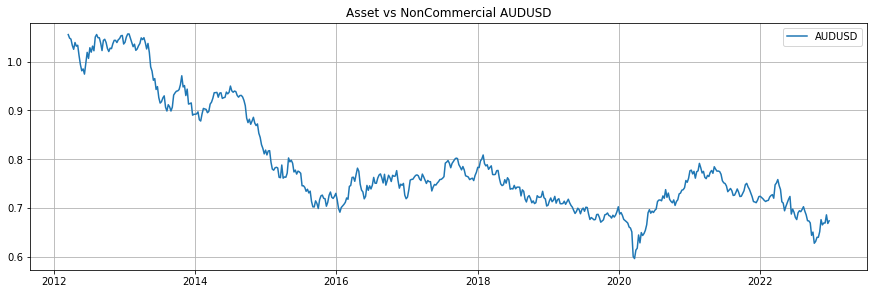

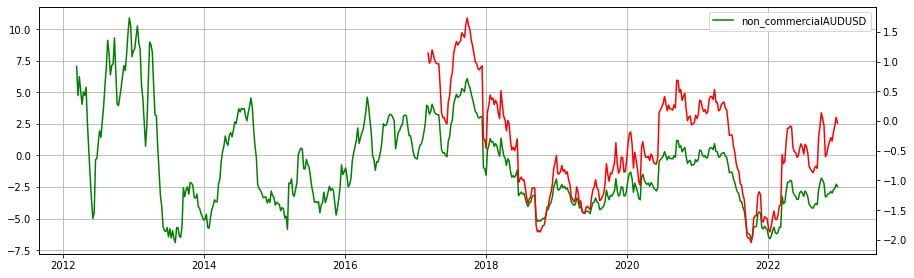

EURUSD


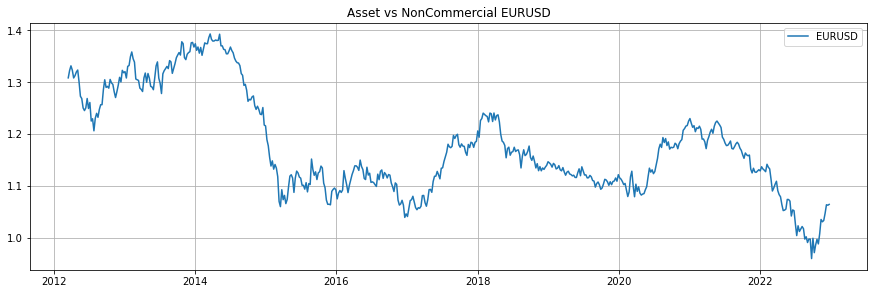

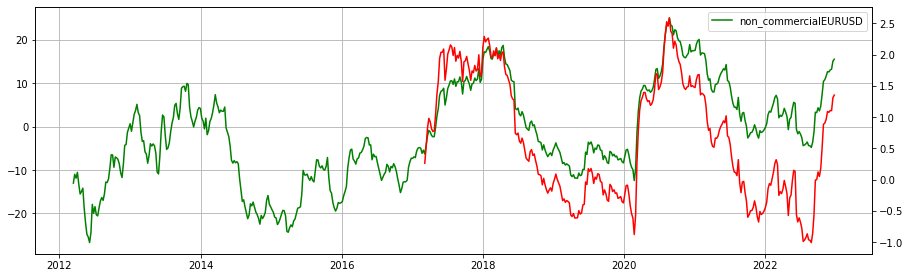

GBPUSD


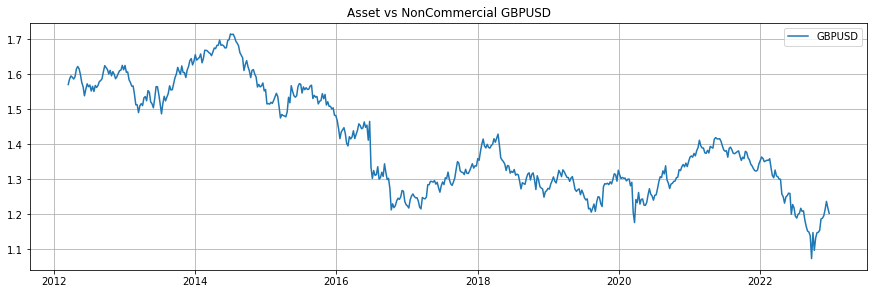

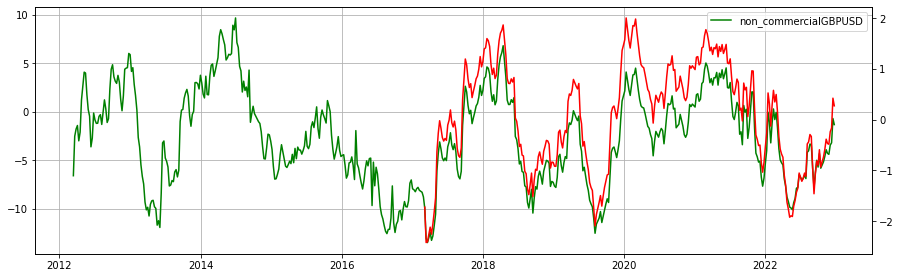

NZDUSD


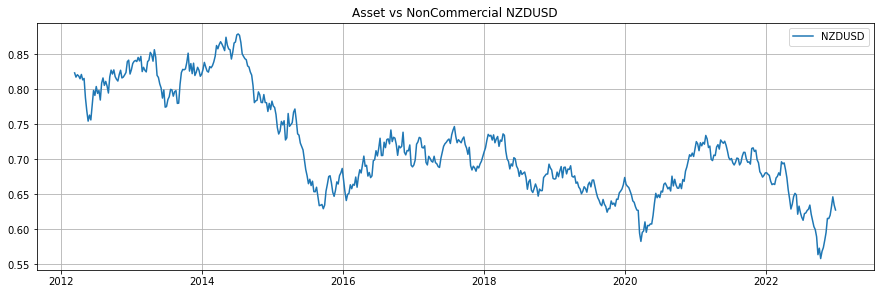

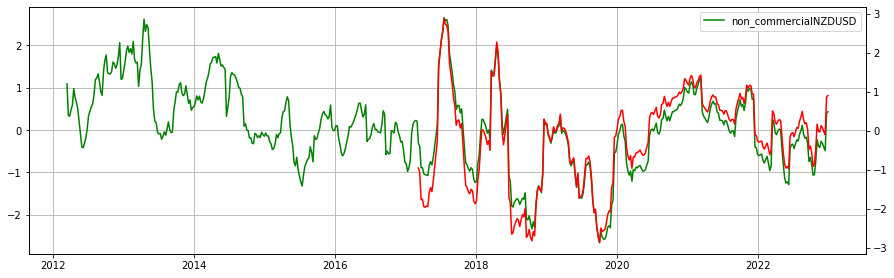

USDCAD


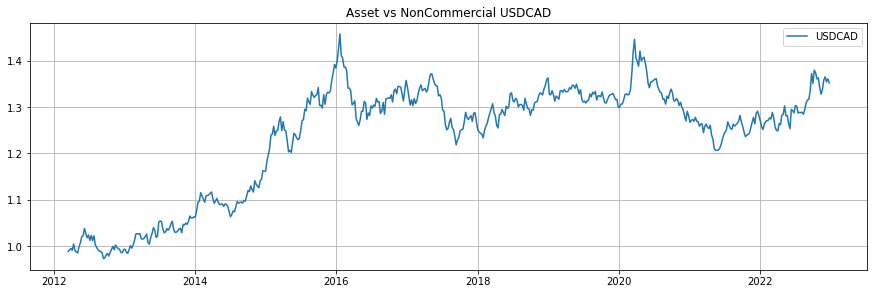

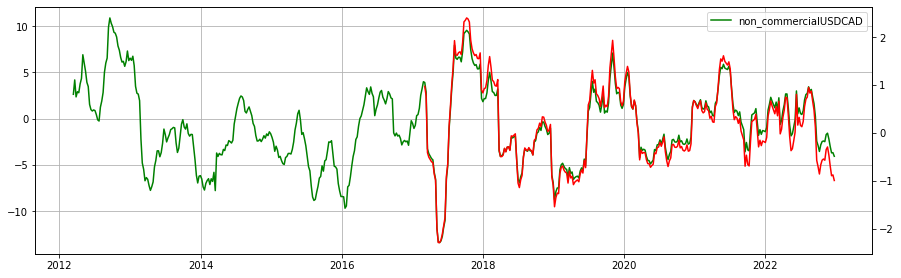

USDJPY


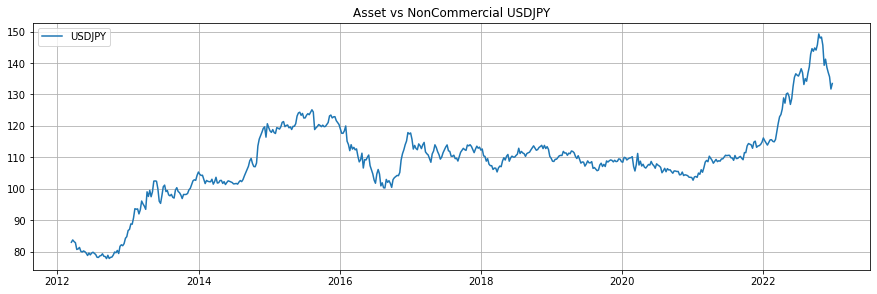

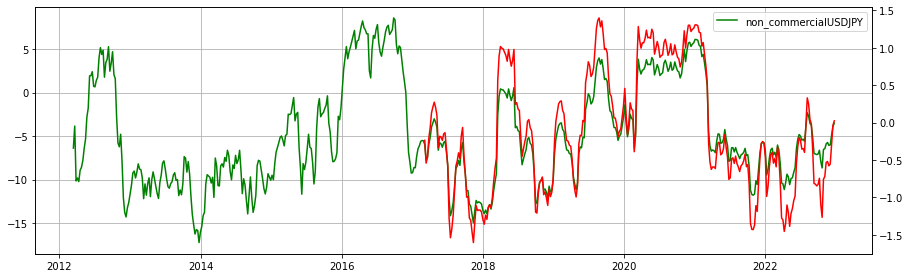

In [16]:
def plot(d):       
    
    '''The 0th column is prices,  
    the 7 (ie 6th) is billions spec, the 6 (ie 5th) is z score
    2nd chart left axis, right axis is z score'''
    
    y = (d.iloc[:, 0], d.iloc[:,6], d.iloc[:,5])

    plt.figure(figsize = (15,10))
    plt.subplot(211) # 1st plot settings start here: (*nrows*, *ncols*, *index*/position)
    
    #plot underlying security
    plt.plot(y[0], lw = 1.5, label = d.columns[0])
    plt.grid(True)
    plt.legend(loc=0)
    plt.axis('tight')

    plt.title('Asset vs NonCommercial '+ str(d.columns[0]))
    
    #now plot specs and zscore
    fig, ax1 = plt.subplots(figsize=(15,10)) # chart two series with different scales

    plt.subplot(212) # 2nd plot settings start here:
    
    
    plt.plot(y[1], 'g', lw = 1.5, label = 'non_commercial'+str(d.columns[0]))#plt.plot(y[:, 1], 'g', lw = 1.5, label = 'spec')
    #this has bug, double label on left y# plt.twinx().plot(y[1], 'g', lw = 1.5, label = 'non_commercial'+str(d.columns[0]))#plt.plot(y[:, 1], 'g', lw = 1.5, label = 'spec')
    plt.grid(True)
    plt.legend(loc=0)
    plt.axis('tight')
    plt.twinx().plot(y[2] , 'r', label = 'zscore')
    
    #ax2 = ax1.twinx()
    #plt.plot(y[2], 'r')
    
    plt.show()

for i in (fx):
    print(i)
    plot(d = fx[i])

TU1


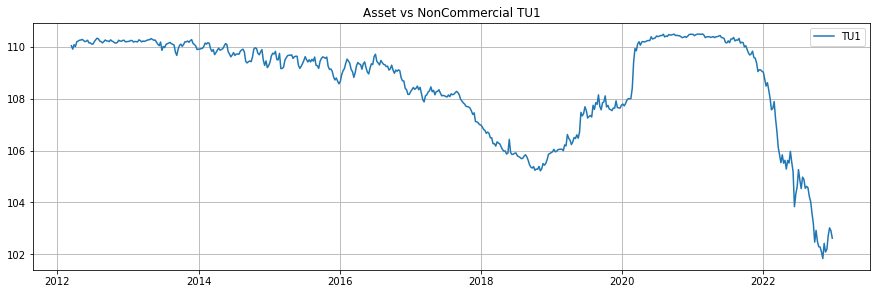

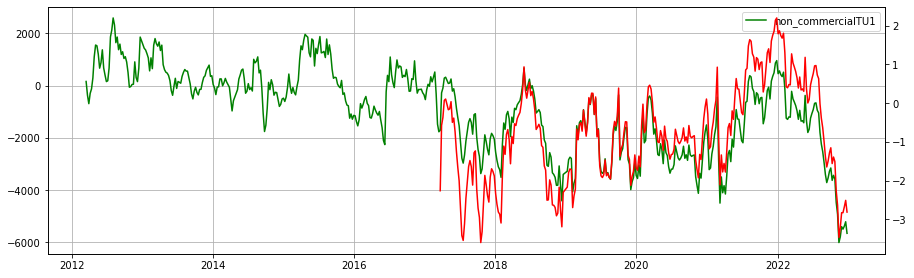

FV1


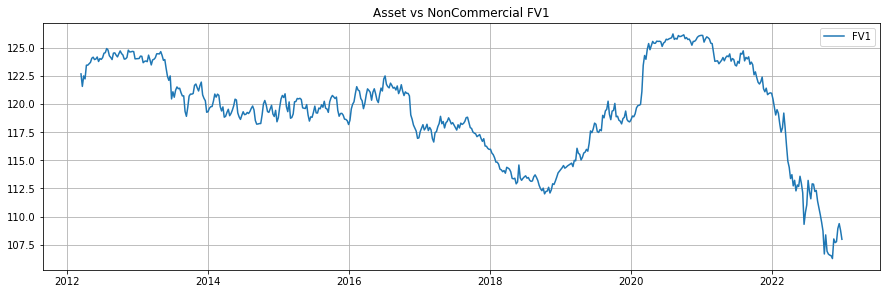

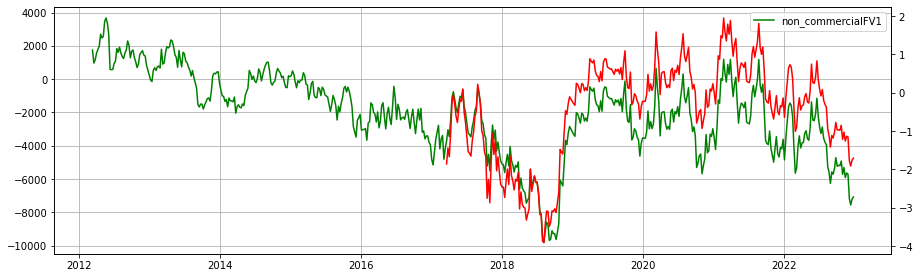

TY1


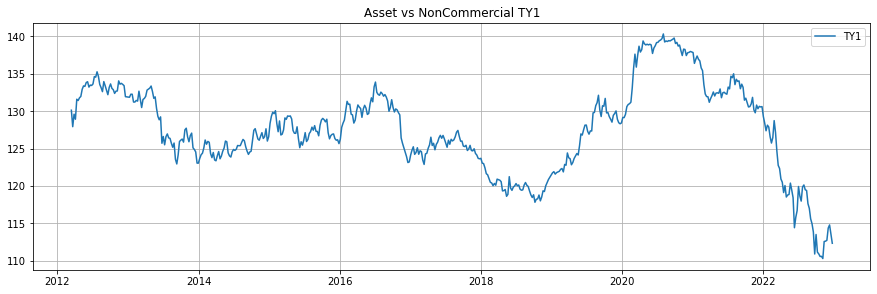

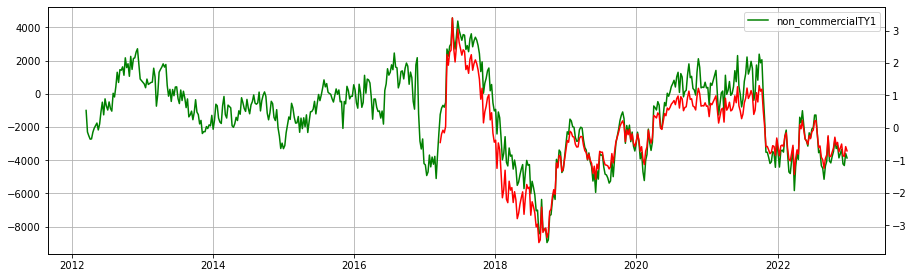

US1


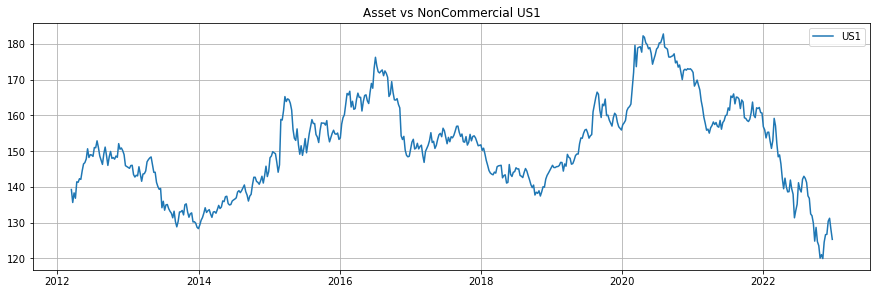

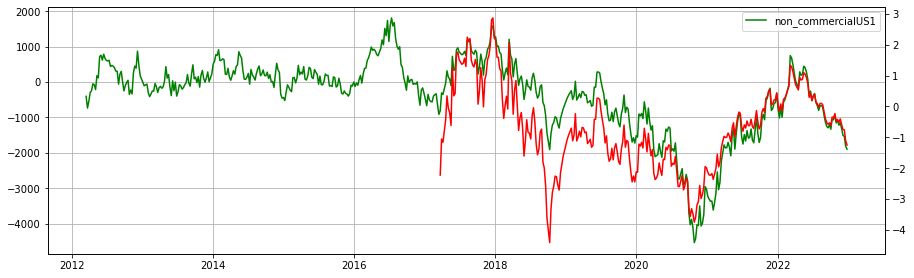

In [17]:

for i in (rates):
    print(i)
    plot(d = rates[i])

In [18]:
page_title_text = 'My report'
title_text = 'COT report'
text = 'welcome '
prices_text = 'historical prices'
stats_text = 'historical stats'

html = f'''
    <html>
        <head>
            <title>{page_title_text}</title>
        </head>
        <body>
            <h1>{title_text}</h1>
            <p>{text}</p>
            {fx['AUDUSD'].tail(10).append(fx['AUDUSD'].describe()).to_html()}
        </body>
    </html>
    '''
with open('html_report.html', 'w') as f:
    f.write(html)

##jinja 2 put special placeholds in template to allwo code simialr to python sytnax
#requires a report_template.html file (can create one with text editor)

In [19]:
from jinja2 import Environment, FileSystemLoader


In [20]:
env = Environment(loader = FileSystemLoader('templates_html'))
template = env.get_template('report_template.html')

html = template.render(page_title_text = "My report",
                       title_text = 'COT Report',
                       text = 'yada',
                       AUDUSD = fx['AUDUSD'].tail(10).append(fx['AUDUSD'].describe()).to_html())

with open('html_report_jinja.html', 'w') as f:
    f.write(html)